# SWEM On Amazon Data

## Prepare Data

### Import packages and GloVe 

In [91]:
import gensim
import logging
from gensim.scripts.glove2word2vec import glove2word2vec

from keras import *
import pandas as pd
import numpy as np
import tensorflow as tf
import numpy as np
from tensorflow.contrib import layers

import itertools
from collections import Counter

import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


dat_path = "./data/"

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [32]:
# Utility functions
from utils import tokenizer, word2id_id2word_dicts, prepare_data_for_emb, token_to_id,\
    load_embedding_vectors_glove_gensim, get_minibatches_idx

In [33]:
# Model functions
from model import embedding, aver_emb_encoder, max_emb_encoder, concat_emb_encoder,\
    discriminator_2layer

In [34]:
glove_embd = dat_path + 'embeddings/glove.6B.300d.txt.word2vec'

### Load Amazon Review Data

In [35]:
df_raw = pd.read_csv(dat_path + "amazonreviews/train.ft.txt", sep = "\t", names = ["row"])

In [36]:
# Function to transform input data to a workable dataframe
# Input: text data
# Output: pandas dataframe
def dat_prepare(df):
    new = df
    new = pd.DataFrame(new.row.str.split(':', 1).tolist(), columns = ['label','review'])
    new1 = new
    new1 = pd.DataFrame(new1.label.str.split(' ', 1).tolist(), columns = ['label','content'])
    new1['review'] = new['review']
    return new1

In [37]:
df = dat_prepare(df_raw)
len(df)

3600000

## Prepare Training/Testing Data

In [38]:
# Subset 10000 samples from the entire dataset
# Subset train/test data from the original dataset to reduce the computing cost
n = 10000
review_data = df[0:n] 

In [39]:
# All data
x_data = review_data['review']

y_label = review_data['label']
y_label = np.where(y_label == '__label__2', 1, 0)

In [40]:
class opt(object):
    def __init__(self):
        # Maximum number of words in a review
        self.embeddings = None
        self.maxlen = None
        # Number of unique words in all reviews
        self.uniq_words = None
        # Vector size for each word embeddings from GloVe
        self.emb_size = 300
        # Training Batch Size
        self.batch_size = 50
        # Epoch
        self.epoch = 101
        # Learning rate
        self.lr_rate = 0.01
        # Dropout - keep rate
        self.dropout = 0.5
        # Number of hidden layers
        self.H_dis = None

In [41]:
# initialize model options
opt = opt()

In [42]:
# Tokenize
x_tokenized = x_data.apply(tokenizer)
print("Finish tokenizing...")

# word2id, id2word
x_word2id = word2id_id2word_dicts(x_tokenized)[0]
x_id2word = word2id_id2word_dicts(x_tokenized)[1]
print("Finish creating word2id, id2word matrices", len(x_word2id), len(x_id2word))

Finish tokenizing...
Finish creating word2id, id2word matrices 4471 4471


In [43]:
# assigning ids to tokens
token_id_mat = [token_to_id(x, x_word2id) for x in x_tokenized]
print("Finish creating token to id matrix: ", len(token_id_mat))

Finish creating token to id matrix:  10000


In [44]:
# Word Vectors
x_word_embeddings = load_embedding_vectors_glove_gensim(x_word2id, glove_embd)

2019-05-19 23:59:08,495 : INFO : loading projection weights from ~/Documents/DCRI/PAD_ML/Code/data/embeddings/glove.6B.300d.txt.word2vec


loading embedding


2019-05-20 00:00:46,494 : INFO : loaded (400000, 300) matrix from ~/Documents/DCRI/PAD_ML/Code/data/embeddings/glove.6B.300d.txt.word2vec


num of vocab in glove: 4402
num of vocab not in glove: 69


In [45]:
opt.maxlen = np.max([len(s) for s in x_tokenized])
opt.uniq_words = len(x_word2id)
opt.embeddings = x_word_embeddings
opt.H_dis = 150

### Define Training Model Class

In [46]:
spl_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
n_train = int(n*spl_ratio)
n_val = int(n*val_ratio)
n_test = int(n*test_ratio)
train = token_id_mat[0:n_train]
val = token_id_mat[n_train:n_train+n_val]
test = token_id_mat[n_train+n_val:n]

In [47]:
train_lab = y_label[0:n_train]
val_lab = y_label[n_train:n_train+n_val]
test_lab = y_label[n_train+n_val:n]

### Define SWEM Model

In [74]:
def emb_classifier_max(x, x_mask, y, dropout, opt):
    # print x.get_shape()  # batch L
    x_emb, W_emb = embedding(x, opt)  # batch L emb
    print("size of embedding: ", x_emb.shape)
    x_emb = tf.expand_dims(x_emb, 3)  # batch L emb 1
    
    print("Input size for encoding x_emb: ", x_emb.shape)
    H_enc = max_emb_encoder(x_emb, x_mask, opt)
    
    print("Encoder shape: ", H_enc.shape)
    
    logits = discriminator_2layer(H_enc, opt, dropout, prefix='classify_', num_outputs=1, is_reuse=None)
    prob = tf.nn.sigmoid(logits)

    # Accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(prob), y), tf.float32))

    # Loss function
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))

    # Training Step
    train_step = tf.train.AdamOptimizer(opt.lr_rate).minimize(loss)   
    return prob, accuracy, loss, train_step, W_emb

In [79]:
def emb_classifier_aver(x, x_mask, y, dropout, opt):
    # print x.get_shape()  # batch L
    x_emb, W_emb = embedding(x, opt)  # batch L emb
    print("size of embedding: ", x_emb.shape)
    x_emb = tf.expand_dims(x_emb, 3)  # batch L emb 1
    
    print("Input size for encoding x_emb: ", x_emb.shape)
    H_enc = aver_emb_encoder(x_emb, x_mask)
    
    print("Encoder shape: ", H_enc.shape)
    
    logits = discriminator_2layer(H_enc, opt, dropout, prefix='classify_', num_outputs=1, is_reuse=None)
    prob = tf.nn.sigmoid(logits)

    # Accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(prob), y), tf.float32))

    # Loss function
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))

    # Training Step
    train_step = tf.train.AdamOptimizer(opt.lr_rate).minimize(loss)   
    return prob, accuracy, loss, train_step, W_emb

In [84]:
def emb_classifier_concat(x, x_mask, y, dropout, opt):
    # print x.get_shape()  # batch L
    x_emb, W_emb = embedding(x, opt)  # batch L emb
    print("size of embedding: ", x_emb.shape)
    x_emb = tf.expand_dims(x_emb, 3)  # batch L emb 1
    
    print("Input size for encoding x_emb: ", x_emb.shape)
    H_enc = concat_emb_encoder(x_emb, x_mask, opt)
    
    print("Encoder shape: ", H_enc.shape)
    
    logits = discriminator_2layer(H_enc, opt, dropout, prefix='classify_', num_outputs=1, is_reuse=None)
    prob = tf.nn.sigmoid(logits)

    # Accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(prob), y), tf.float32))

    # Loss function
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))

    # Training Step
    train_step = tf.train.AdamOptimizer(opt.lr_rate).minimize(loss)   
    return prob, accuracy, loss, train_step, W_emb

### Define Training Model (Max pooling)

In [85]:
tf.reset_default_graph()
# Define the model input
x_ = tf.placeholder(tf.int32, shape=[None, opt.maxlen])
x_mask_ = tf.placeholder(tf.float32, shape=[None, opt.maxlen])
keep_prob = tf.placeholder(tf.float32)
y_ = tf.placeholder(tf.float32, shape=[None, 1])
prob_, accuracy_, loss_, train_step, W_emb_ = emb_classifier_concat(x_, x_mask_, y_, keep_prob, opt)
# prob_, accuracy_, loss_, train_step, W_emb_ = emb_classifier_max(x_, x_mask_, y_, keep_prob, opt)
# prob_, accuracy_, loss_, train_step, W_emb_ = emb_classifier_aver(x_, x_mask_, y_, keep_prob, opt)

initialize word embedding finished
size of embedding:  (?, 206, 300)
Input size for encoding x_emb:  (?, 206, 300, 1)
Encoder shape:  (?, 600)


### Define Training Step

Train accuracy 0.818000 
Validation accuracy 0.836000 
Epoch: 0 	 Train Loss: 0.5054317116737366
------------------------------------------------------
Train accuracy 0.836000 
Validation accuracy 0.853000 
Epoch: 1 	 Train Loss: 0.49620312452316284
------------------------------------------------------
Train accuracy 0.853000 
Validation accuracy 0.837000 
Epoch: 2 	 Train Loss: 0.4026777744293213
------------------------------------------------------
Train accuracy 0.837000 
Validation accuracy 0.843000 
Epoch: 3 	 Train Loss: 0.20640811324119568
------------------------------------------------------
Train accuracy 0.843000 
Validation accuracy 0.845000 
Epoch: 4 	 Train Loss: 0.3084617555141449
------------------------------------------------------
Train accuracy 0.845000 
Validation accuracy 0.836000 
Early Stopping. 
Epoch: 5 	 Val Acc: 0.835999995470047 	 Train Acc: 0.9166249975562095


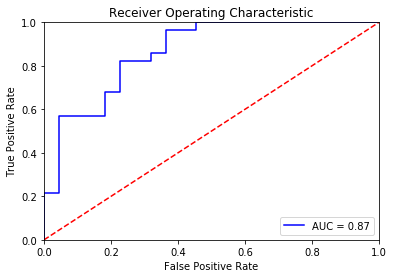

Test accuracy 0.8409999966621399 Test AUC 0.8652597402597402


In [92]:
opt.epoch = 10
max_val_acc = 0
counter = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(opt.epoch):
        train_correct = 0.0
        kf = get_minibatches_idx(n_train, opt.batch_size, shuffle=True)
        for _, train_index in kf:
            sents = [train[t] for t in train_index]
            x_labels = [train_lab[t] for t in train_index]
            x_labels = np.array(x_labels)
            x_labels = x_labels.reshape([-1,1])
            
            x_batch, x_batch_mask = prepare_data_for_emb(sents, opt)
            train_acc, _, loss = sess.run([accuracy_, train_step, loss_], feed_dict={x_: x_batch, x_mask_: x_batch_mask, y_: x_labels, keep_prob: opt.dropout})
            
            train_correct += train_acc * len(train_index)
        train_accuracy = train_correct / n_train
        print("Train accuracy %f " % val_accuracy)
        
        # Early Stopping Validation
        val_correct = 0.0
        kf_val = get_minibatches_idx(n_val, opt.batch_size, shuffle=True)
        for _, val_index in kf_val:
            val_sents = [val[t] for t in val_index]
            val_labels = [val_lab[t] for t in val_index]
            val_labels = np.array(val_labels)
            val_labels = val_labels.reshape([-1,1])
            x_val_batch, x_val_batch_mask = prepare_data_for_emb(val_sents, opt)

            val_prob, val_acc = sess.run([prob_, accuracy_], feed_dict={x_: x_val_batch, x_mask_: x_val_batch_mask,
                                                          y_: val_labels, keep_prob: 1.0})

            val_true_lab = val_labels
            val_correct += val_acc * len(val_index)

        val_accuracy = val_correct / n_val
        print("Validation accuracy %f " % val_accuracy)

        if val_accuracy > max_val_acc:
            max_val_acc = val_accuracy
            counter = 0
        else:
            counter += 1
        if counter > 3:
            print("Early Stopping. ")
            print("Epoch: {0} \t Val Acc: {1} \t Train Acc: {2}".format(epoch, val_accuracy, train_accuracy))
            test_correct = 0.0
            kf_test = get_minibatches_idx(n_test, opt.batch_size, shuffle=True)
            for _, test_index in kf_test:
                test_sents = [test[t] for t in test_index]
                test_labels = [test_lab[t] for t in test_index]
                test_labels = np.array(test_labels)
                test_labels = test_labels.reshape([-1,1])
                x_test_batch, x_test_batch_mask = prepare_data_for_emb(test_sents, opt)

                test_prob, test_acc = sess.run([prob_, accuracy_],
                                         feed_dict={x_: x_test_batch, x_mask_: x_test_batch_mask,
                                                    y_: test_labels, keep_prob: 1.0})

                test_correct += test_acc * len(test_index)

            test_accuracy = test_correct / len(test)
            
            fpr, tpr, threshold = metrics.roc_curve(test_labels, test_prob)
            roc_auc = metrics.auc(fpr, tpr)
            plt.figure()
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()

            print("Test accuracy {0} Test AUC {1}".format(test_accuracy, roc_auc))
            break

        print("Epoch: {0} \t Train Loss: {1}".format(epoch, loss))
        print("------------------------------------------------------")

In [95]:
uidx = 0
max_val_accuracy = 0.
max_test_accuracy = 0.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    try:
        for epoch in range(5):
            print("====================================================")
            print("Starting epoch %d" % epoch)
            kf = get_minibatches_idx(n_train, opt.batch_size, shuffle=True)
            for _, train_index in kf:
                uidx += 1
                sents = [train[t] for t in train_index]
                x_labels = [train_lab[t] for t in train_index]
                x_labels = np.array(x_labels)
                x_labels = x_labels.reshape([-1,1])

                x_batch, x_batch_mask = prepare_data_for_emb(sents, opt)
                _, loss = sess.run([train_step, loss_], feed_dict={x_: x_batch, x_mask_: x_batch_mask, y_: x_labels, keep_prob: opt.dropout})
                
                # Validation for every 20 iterations
                if uidx % 20 == 0:
                    train_correct = 0.0
                    kf_train = get_minibatches_idx(500, opt.batch_size, shuffle=True)
                    for _, train_index in kf_train:
                        train_sents = [train[t] for t in train_index]
                        train_labels = [train_lab[t] for t in train_index]
                        train_labels = np.array(train_labels)
                        train_labels = train_labels.reshape([-1,1])
                        x_train_batch, x_train_batch_mask = prepare_data_for_emb(train_sents, opt)  # Batch L

                        train_accuracy = sess.run(accuracy_, feed_dict={x_: x_train_batch, x_mask_: x_train_batch_mask, y_: train_labels, keep_prob: 1.0})

                        train_correct += train_accuracy * len(train_index)

                    train_accuracy = train_correct / 500
                    print("-------------------------------------------------------")
                    print("Iteration %d: Training loss %f " % (uidx, loss))
                    print("Train accuracy %f " % train_accuracy)

                    val_correct = 0.0
                    kf_val = get_minibatches_idx(n_val, opt.batch_size, shuffle=True)
                    for _, val_index in kf_val:
                        val_sents = [val[t] for t in val_index]
                        val_labels = [val_lab[t] for t in val_index]
                        val_labels = np.array(val_labels)
                        val_labels = val_labels.reshape([-1,1])
                        x_val_batch, x_val_batch_mask = prepare_data_for_emb(val_sents, opt)

                        val_accuracy = sess.run(accuracy_, feed_dict={x_: x_val_batch, x_mask_: x_val_batch_mask,
                                                                      y_: val_labels, keep_prob: 1.0})

                        val_correct += val_accuracy * len(val_index)

                    val_accuracy = val_correct / n_val
                    print("Validation accuracy %f " % val_accuracy)

                    if val_accuracy > max_val_accuracy:
                        max_val_accuracy = val_accuracy

                        test_correct = 0.0
                        kf_test = get_minibatches_idx(n_test, opt.batch_size, shuffle=True)
                        for _, test_index in kf_test:
                            test_sents = [test[t] for t in test_index]
                            test_labels = [test_lab[t] for t in test_index]
                            test_labels = np.array(test_labels)
                            test_labels = test_labels.reshape([-1,1])
                            x_test_batch, x_test_batch_mask = prepare_data_for_emb(test_sents, opt)

                            test_accuracy = sess.run(accuracy_,
                                                     feed_dict={x_: x_test_batch, x_mask_: x_test_batch_mask,
                                                                y_: test_labels, keep_prob: 1.0})

                            test_correct += test_accuracy * len(test_index)

                        test_accuracy = test_correct / n_test

                        print("Test accuracy %f " % test_accuracy)

                        max_test_accuracy = test_accuracy

            print("Epoch %d: Max Test accuracy %f" % (epoch, max_test_accuracy))

#             emb = sess.run(W_emb_, feed_dict={x_: x_test_batch})

#             cPickle.dump([emb], open("yahoo_emb_max_300.p", "wb"))

        print("Max Test accuracy %f " % max_test_accuracy)

    except KeyboardInterrupt:
        # print 'Training interupted'
        print('Training interupted')
        print("Max Test accuracy %f " % max_test_accuracy)


Starting epoch 0
-------------------------------------------------------
Iteration 20: Training loss 0.692127 
Train accuracy 0.526000 
Validation accuracy 0.541000 
Test accuracy 0.537000 
-------------------------------------------------------
Iteration 40: Training loss 0.693328 
Train accuracy 0.506000 
Validation accuracy 0.481000 
-------------------------------------------------------
Iteration 60: Training loss 0.692074 
Train accuracy 0.494000 
Validation accuracy 0.519000 
-------------------------------------------------------
Iteration 80: Training loss 0.686325 
Train accuracy 0.494000 
Validation accuracy 0.519000 
-------------------------------------------------------
Iteration 100: Training loss 0.691715 
Train accuracy 0.494000 
Validation accuracy 0.519000 
-------------------------------------------------------
Iteration 120: Training loss 0.694553 
Train accuracy 0.494000 
Validation accuracy 0.519000 
-------------------------------------------------------
Iterati